## Kaggle Baseball Dataset
This project requires basic knowledge of the sport of baseball and statistical concepts and baseball terminology. The data set is located in this folder.

Per Instructions, the following questions are below:

1) What are the top 3 colleges that have historically produced the best value at third base judged by their total RBI output, versus their total career salary, judged against other players at the position?

2) Is there a correlation between the year a player was born and how many walks they have in their career?

3) Based on the last 100 players who have made the all star game at shortstop, what is the most important statistical characteristic they all share and why?

4) What stadium/park do you predict will give up the most errors by a center fielder over the next 5 years and why?


In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlite3



### Question 1: What are the top 3 colleges that have historically produced the best value at third base judged by their total RBI output, versus their total career salary, judged against other players at the position?

Strategy:
Salaries have increased since the mid-90s after the Collective Bargaining Agreement was agreed (after the strike). It is going to be difficult to compare year to year as finding best value in terms of salary and rbi. Another issue is the number of games played/appearances. Need to have some minimum number such that we don't compare a player who only played handful of times in one year compared to another player who is an allstar and has played for several years. 

From a Team perspective, they would want a player who will play a number of years and can generate some rbi. Third basemen are generally power hitters who should hit a lot of homeruns and get a lot of rbi.

How can we solve this question? By normalizing (using Min-Max Scaling) within each year for Salary and RBI, we can compare players per year to see their salary to rbi value. Then we can group them by colleges to see, which colleges are at the top.

In [6]:
#batting dataframe
batting = pd.read_csv('../Data/batting.csv')
cols_batting = ['player_id','year','team_id','ab','rbi','bb']
q1b = batting[cols_batting]
print q1b.shape

(101332, 6)


In [7]:
#appearances dataframe to find 3b
appearances = pd.read_csv('../Data/appearances.csv')
cols_appear = ['player_id','year','team_id','g_all','g_3b']
q1a = appearances[cols_appear]
print q1a.shape

(100951, 5)


In [77]:
#player/college dataframe.
pc = pd.read_csv('../Data/player_college.csv')
college = pd.read_csv('../Data/college.csv')
q1c = pd.merge(pc.loc[:,['player_id','college_id']],college.loc[:,['college_id','name_full']],on='college_id')
#how many years did a player go to college
pc1 = pc.groupby(['player_id'])['year'].count().to_frame('years')
pc1.reset_index(inplace = True)

#because of transfers, we need to find out the last college a player went to
max_yr = pc.groupby('player_id')['year'].max().to_frame()
max_yr.reset_index(inplace = True)
#finding the last college a player went to
last_college = pd.merge(pc,max_yr)
#combinging the last college and number of years a player went to college
player_college = pd.merge(last_college,pc1,on='player_id')
player_college.rename(columns = {'year':'grad_yr','years':'college_yrs'},inplace = True)
player_college.shape

(6577, 4)

In [366]:
#salary dataframe
salary = pd.read_csv('../Data/salary.csv')

#merging batting and appearances dataframe
q1temp = pd.merge(q1b,q1a,on=['player_id','year','team_id'])
#merging batting/appearances dataframe and salary dataframe
q1player = pd.merge(q1temp,salary,on=['player_id','year','team_id'])

#check to see salary distribution of players who played on more than 2 teams in a year
teams = q1player.groupby(['player_id','year'])['team_id'].count().to_frame().sort_values('team_id',ascending=False)
teams.reset_index(inplace = True)
sal_team = q1player.groupby(['player_id','year'])['salary'].agg([min,max,sum,np.mean])
sal_team.reset_index(inplace=True)
sal_team = pd.merge(teams,sal_team,on = ['player_id','year'])
sal_team[sal_team['team_id']>1].head(10)
#looks like salaries were split between teams

,player_id,year,team_id,min,max,sum,mean
0,corsiji01,1999,2,200000,750000,950000,475000
1,gaettga01,1993,2,109000,3000000,3109000,1554500
2,olsongr01,1997,2,210000,400000,610000,305000
3,jonesdo01,1996,2,109000,825000,934000,467000
4,clarkje02,2003,2,300000,300000,600000,300000
5,lukema01,1998,2,170000,170000,340000,170000
6,spraged02,2000,2,800000,800000,1600000,800000
7,whisema01,1997,2,150000,150000,300000,150000
8,figgami01,1999,2,203650,203650,407300,203650
9,maddumi01,1995,2,109000,200000,309000,154500


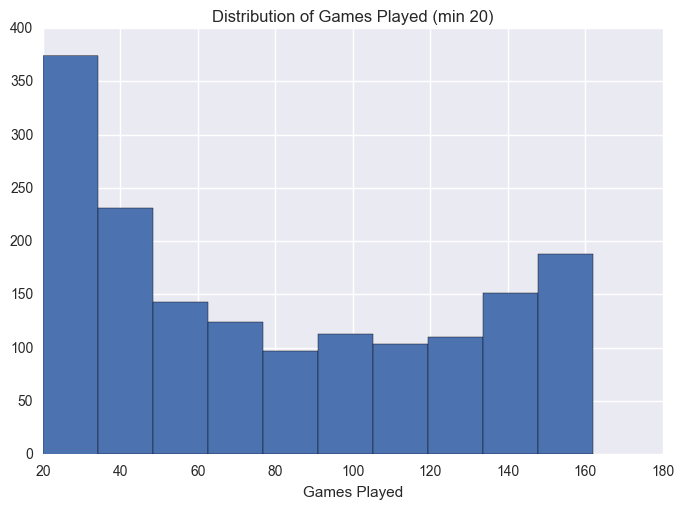

In [15]:
#need to specify some number of min games played at 3b.
#to qualify for a position in the MLB, a player must play a minimum number of games at the position.
q1player[q1player['g_3b']>=20]['g_3b'].hist()
plt.title('Distribution of Games Played (min 20)')
plt.xlabel('Games Played');

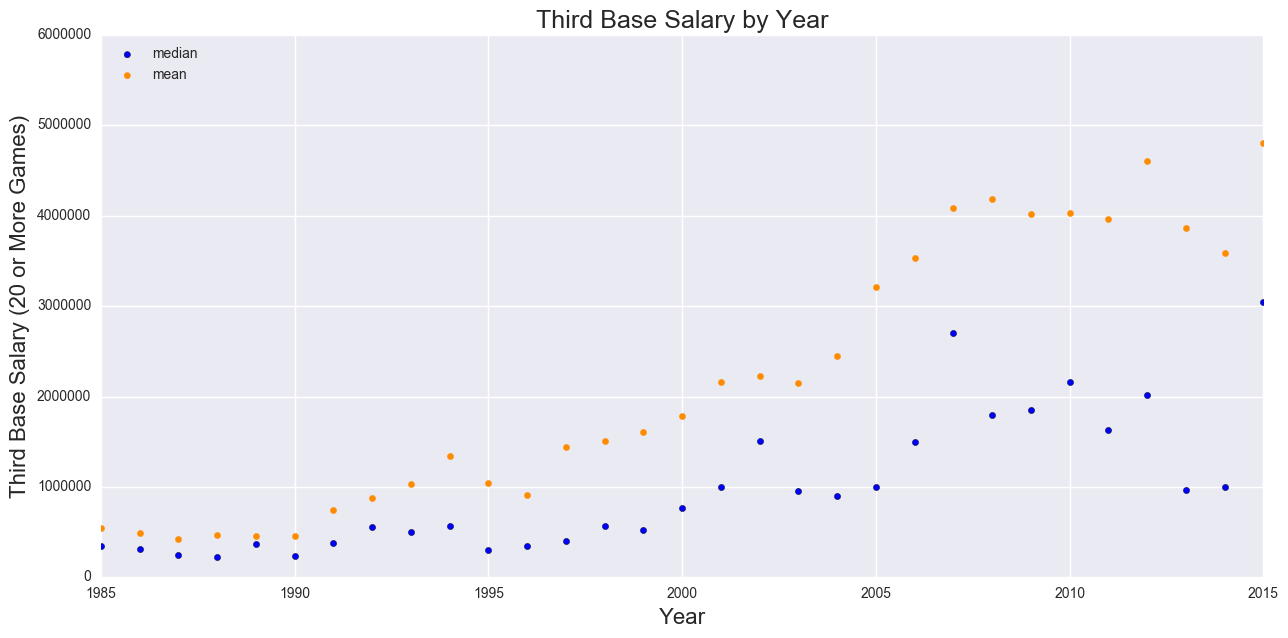

    year  len     min       max   median     mean
0   1985   43   60000   2130300   341667   550772
1   1986   55   60000   2136666   317500   486927
2   1987   48   62500   2127333   242500   428201
3   1988   45   62500   2250000   230000   464485
4   1989   48   68000   2400000   370000   462260
5   1990   50  100000   1900000   235000   461071
6   1991   46  100000   3033333   375000   744552
7   1992   50  109000   3633333   555000   879155
8   1993   54  109000   6200000   500000  1029509
9   1994   46  109000   6300000   562500  1347373
10  1995   61  109000   5850000   300000  1039085
11  1996   65  109000   6600000   350000   911179
12  1997   55  150000   7150000   400000  1441027
13  1998   58  170000   6400000   562500  1508396
14  1999   58  200000   8100000   525000  1602051
15  2000   52  205000   8500000   762500  1779362
16  2001   57  200000  10333333  1000000  2165692
17  2002   58  200000   9500000  1508333  2230310
18  2003   60  165574  10000000   950000  2147085


In [19]:
#using 20 as the min number of games at 3b
games_limit = 20
#finding metrics for salary
sal_by_yr = q1player[q1player['g_3b']>=games_limit].groupby('year')['salary'].agg([len,min,max,np.median,np.mean])
sal_by_yr.reset_index(inplace = True)

#plotting median and mean by year
plt.subplots(figsize=(15,7))
plt.scatter(x=sal_by_yr['year'],y=sal_by_yr['median'],label='median')
plt.scatter(x=sal_by_yr['year'],y=sal_by_yr['mean'],color='darkorange',label='mean')
plt.legend(loc=2)
plt.title('Third Base Salary by Year',fontsize=18)
plt.xlabel('Year',fontsize=16)
plt.ylabel('Third Base Salary (20 or More Games)',fontsize=16)
plt.xlim(1985,2015)
plt.show()


print sal_by_yr
salary1985 = sal_by_yr.loc[0,'mean']
salary2015 = sal_by_yr.loc[30,'mean']
print 'Mean Salary in 1985:',sal_by_yr.loc[0,'mean']
print 'Mean Salary in 2015:',sal_by_yr.loc[30,'mean']
print 'slope of salary is:',(salary2015 - salary1985)/31

Salaries have been increasing since 1985, thus need for normalization. Luxury Tax treshold also has been increasing, thus players salaries have been increasing. Also, rookies are under their rookie contract for first several years, and while they do get arbitration. In 1976, MLB and players association agreed that players with 6 years experience can file for free agency.  In 1996, the Collective Bargaining Agreement was inacted that gave way for Luxury Tax (instead of Salary Cap). As you can see from the graph above, 1995 is when the average salary started increasing. Between 2000 and 2002, the salary cap was gone, and in 2002, Luxury Tax was back, and it has been increasing since then.


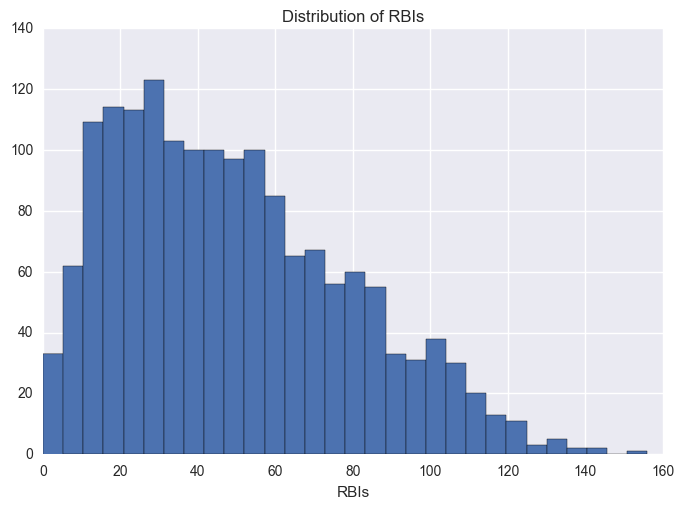

Descriptive Statistics for RBI
count    1631.000000
mean       48.931944
std        29.744881
min         0.000000
25%        25.000000
50%        45.000000
75%        69.000000
max       156.000000
Name: rbi, dtype: float64


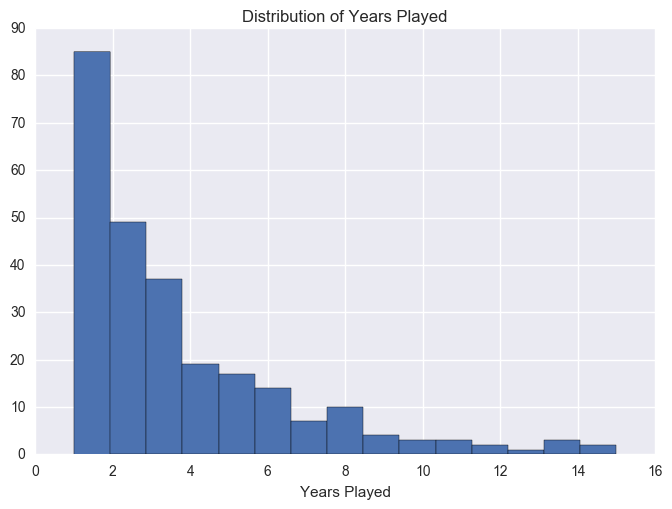

              yrs        g_all         g_3b           ab          rbi  \
count  171.000000   171.000000   171.000000   171.000000   171.000000   
mean     4.625731   532.333333   390.456140  1747.374269   236.912281   
std      3.037072   397.362126   392.124953  1470.601246   230.208444   
min      2.000000    72.000000    45.000000   207.000000    22.000000   
25%      2.000000   251.500000   114.000000   742.500000    86.500000   
50%      3.000000   394.000000   245.000000  1180.000000   143.000000   
75%      6.000000   663.500000   518.500000  2189.000000   333.500000   
max     15.000000  2009.000000  1858.000000  7185.000000  1178.000000   

            N_rbi        salary       N_sal      grad_yr  college_yrs  \
count  171.000000  1.710000e+02  171.000000   171.000000   171.000000   
mean     1.809224  8.663202e+06    0.775406  1991.555556     2.847953   
std      1.898838  1.392358e+07    1.387117    10.127488     0.797226   
min      0.028883  2.250000e+05    0.000000  1965.

In [126]:
#summing games, ab, rbi and salary across player-year. this is because some players got traded.
q1 = q1player[q1player['g_3b']>=games_limit].groupby(['player_id','year'])['g_all','g_3b','ab','rbi','salary'].sum()
q1.reset_index(inplace = True)

#histogram of RBI
q1['rbi'].hist(bins=30)
plt.title('Distribution of RBIs')
plt.xlabel('RBIs')
plt.show();

print 'Descriptive Statistics for RBI'
print q1['rbi'].describe()

#need to have a lower limit on RBIs, lets put it at 5 from the histogram below

q1 = q1[q1['rbi']>5]

#finding min/max for rbi and salary to do min-max scaling to get between 0 and 1
std_rbi = q1.groupby('year')['rbi'].agg([min, max]).rename(columns={'min':'rbi_min','max':'rbi_max'})
std_rbi.reset_index(inplace = True)
std_salary = q1.groupby('year')['salary'].agg([min, max]).rename(columns={'min':'sal_min','max':'sal_max'})
std_salary.reset_index(inplace = True)

#merging scaling metrics (mean and standard deviation) for rbi and salary
std = pd.merge(std_rbi,std_salary)

#merging q1 and the combined scaling metrics
q1_std = pd.merge(q1,std,on='year')

#creating normalized rbi, salary, and ratio of salary/rbi
q1_std['N_rbi'] = (q1_std['rbi'] - q1_std['rbi_min']) / (q1_std['rbi_max']-q1_std['rbi_min'])
q1_std['N_sal'] = (q1_std['salary'] - q1_std['sal_min']) / (q1_std['sal_max']-q1_std['sal_min'])
q1_std['N_sal/rbi'] = (q1_std['N_sal'] / q1_std['N_rbi'])
q1_std[q1_std['rbi']<20]

#question asked for career value
q1_p1 = q1_std.groupby('player_id')['year','g_all','g_3b','ab','rbi','salary','N_rbi','N_sal'].\
        agg({'year':len,'g_all':sum,'g_3b':sum,'ab':sum,'rbi':sum,'salary':sum,'N_rbi':sum,'N_sal':sum}).rename(columns={'year':'yrs'})

q1_p1.reset_index(inplace = True)
q1_p1 = q1_p1.loc[:,['player_id','yrs','g_all','g_3b','ab','rbi','N_rbi','salary','N_sal']]
#need to bring in college, so lets merge with the player/college df
q1_p2 = pd.merge(q1_p1,player_college)
q1_p2['N_sal/rbi'] = q1_p2['N_sal'] / q1_p2['N_rbi']

#what is the point of having only 1 years experience, that would not provide value. judging by histogram, lets cut off at 2
q1_p2['yrs'].hist(bins=15)
plt.title('Distribution of Years Played')
plt.xlabel('Years Played')
plt.show()
#descriptive stats
print q1_p2[q1_p2['yrs']>1].describe()

#limiting to 2 years and above
q1_p2 = q1_p2[q1_p2['yrs']>1]

#find the rbi and salary min/max
rbi_aggmin = q1_p2['rbi'].min()
rbi_aggmax = q1_p2['rbi'].max()
rbi_aggdiff = rbi_aggmax - rbi_aggmin
sal_aggmin = q1_p2['salary'].min()
sal_aggmax = q1_p2['salary'].max()
sal_aggdiff = sal_aggmax - sal_aggmin
q1_p2['N_rbiagg'] = q1_p2['rbi'].apply(lambda x: (x-rbi_aggmin)/rbi_aggdiff)
#q1_p2['N_salagg'] = q1_p2['salary'].apply(lambda x: (x-sal_aggmin)/sal_aggdiff)
q1_p2['N_salagg'] = (q1_p2['salary'] - sal_aggmin)/sal_aggdiff

q1_p2['N_sal/rbi_agg'] = q1_p2['N_salagg'] / q1_p2['N_rbiagg']
q1_p2.sort_values('N_sal/rbi_agg')

#there is one observation where there is infinity, lets remove that
q1_p2 = q1_p2[q1_p2['N_rbiagg']>0]

In [135]:
#finding the number of player from a college
college_count = q1_p2.groupby('college_id')['yrs'].count().to_frame('count')
college_count.reset_index(inplace = True)

#finding the average metrics
q1p3 = q1_p2.groupby('college_id')['yrs','N_salagg','N_rbiagg','N_sal/rbi_agg'].mean()
q1p3.reset_index(inplace = True)

#merging college count and average metrics
q1p4 = pd.merge(college_count,q1p3).sort_values('count',ascending=False)

#given that we want to find the 3 colleges with the best value, need to have a college with more than 2 players
q1p4 = q1p4[q1p4['count']>2]
print 'Number of Colleges evaluated:',q1p4.shape[0]
q1p4.sort_values('N_rbiagg')

Number of Colleges evaluated: 13


,college_id,count,yrs,N_salagg,N_rbiagg,N_sal/rbi_agg
2,arizonast,3,2.333333,0.012111,0.010092,1.990010
52,lsu,4,3.000000,0.007619,0.025735,1.646168
63,nebraska,3,2.333333,0.013291,0.071223,0.203453
92,texas,3,3.000000,0.045609,0.098039,0.719112
60,minnesota,4,3.500000,0.036514,0.099697,1.676997
57,miamifl,7,3.285714,0.047190,0.100470,0.364552
114,wichitast,3,4.000000,0.120680,0.168973,0.382090
50,longbeach,3,3.666667,0.128882,0.200980,0.803640
91,tennessee,4,6.000000,0.203263,0.260164,0.738886
85,stanford,3,6.333333,0.112429,0.279412,1.110220


For question 1, the data was limited to 20+ games at third base, rbi > 5 per  year, and when aggregated over career, the player must have had at least 2 years experience. When evaluating colleges, the college must have had at least 3 players to indicate what kind of players it produces. RBI and Salary were normalized using min-max scaling

Per the table above, we want to find the ratio where RBI is higher than Salary (average). But the way the ratios are, it isn't necessarily clear. Sorting by N_rbiagg (normalized rbi), we want to find the highest value which also has minimized salary (N_salagg). I also want maximize the number of years, as that would indicate the value of a player (a team would not want to draft players that would wash out within 2-3 years). 

With that in mind, I would say that UCLA, USC, Cal State Fullerton would be the top 3 colleges. Salaries are higher than other colleges, but their players hit more RBIs, which generates runs,and thus, would be higher ranked (and favored by teams) than the players who do not hit as much RBIs. 



### Question 2: Is there a correlation between the year a player was born and how many walks they have in their career?


Strategy:
Plot Year Born by Career Walks.

Amount of Null Records
player_id       0
birth_year    143
dtype: int64
Player Birthyear shape: (18846, 2)
Player Birthyear shape after nulls dropped: (18703, 2)
Number of null values: player_id       0
ab            427
bb            427
birth_year      0
dtype: int64


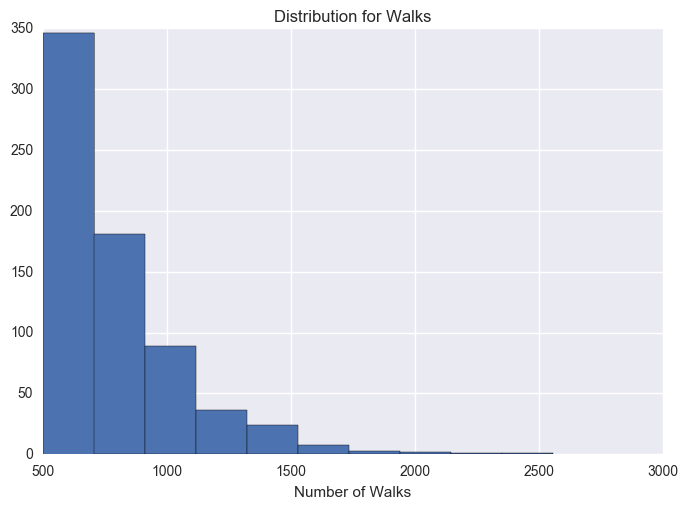

                 ab           bb   birth_year
count    691.000000   691.000000   691.000000
mean    6448.759768   784.865412  1935.513748
std     1826.626439   277.020541    34.717256
min     2595.000000   501.000000  1850.000000
25%     5030.500000   583.000000  1910.000000
50%     6241.000000   705.000000  1944.000000
75%     7611.000000   893.000000  1964.000000
max    14053.000000  2558.000000  1987.000000
                  ab        bb  birth_year
ab          1.000000  0.583384   -0.013201
bb          0.583384  1.000000    0.017943
birth_year -0.013201  0.017943    1.000000


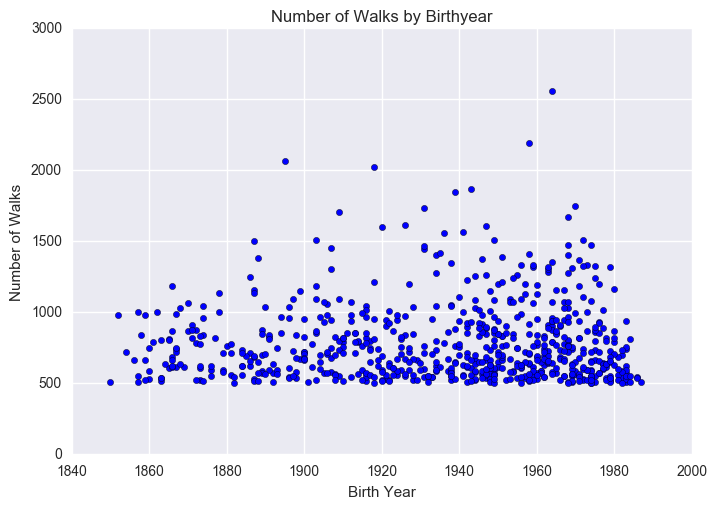

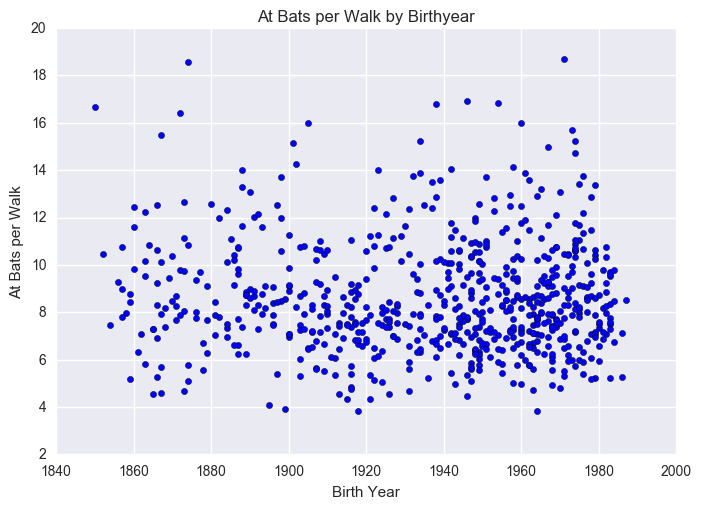

In [389]:
player_data = pd.read_csv('../Data/player.csv')
player_birthyr = player_data.iloc[:,:2]
print 'Amount of Null Records'
print player_birthyr.isnull().sum()
print 'Player Birthyear shape:',player_birthyr.shape
player_birthyr.dropna(inplace = True)
player_birthyr['birth_year'] = player_birthyr['birth_year'].astype(int)
print 'Player Birthyear shape after nulls dropped:',player_birthyr.shape
ab_bb = batting.groupby(['player_id'])['ab','bb'].sum()
ab_bb.reset_index(inplace = True)
q2 = pd.merge(ab_bb,player_birthyr)

print 'Number of null values:',q2.isnull().sum()
q2.dropna(inplace = True)

q2a = q2[q2['bb']>500].copy()

q2a['bb'].hist()
plt.title('Distribution for Walks')
plt.xlabel('Number of Walks')
plt.show()
#need to remove outliers
print q2a.describe()
#need to have some minimum number of ab
print q2a.corr()
#negligble correlation between bb and birthyear
q2a.sort_values('bb',ascending=False)

plt.scatter(x=q2a['birth_year'],y=q2a['bb'])
plt.title('Number of Walks by Birthyear')
plt.xlabel('Birth Year')
plt.ylabel('Number of Walks')
plt.show()
#no correlation between birth year and career walks.

q2a['ab/bb'] = q2a['ab']/q2a['bb']
plt.scatter(x=q2a['birth_year'],y=q2a['ab/bb'])
plt.title('At Bats per Walk by Birthyear')
plt.xlabel('Birth Year')
plt.ylabel('At Bats per Walk')
plt.show()

In [391]:
q2a.corr()

,ab,bb,birth_year,ab/bb
ab,1.000000,0.583384,-0.013201,0.397417
bb,0.583384,1.000000,0.017943,-0.461952
birth_year,-0.013201,0.017943,1.000000,-0.033459
ab/bb,0.397417,-0.461952,-0.033459,1.000000


#### Q2 Conclusion
There is no correlation between year born and career walks. This is verified by plotting and correlation (table above). I would look at HR vs BB. The power hitters tend to hit for the fences, while contact hitters are usually more patient.

### Question 3: Based on the last 100 players who have made the all star game at shortstop, what is the most important statistical characteristic they all share and why?

Strategy:
Looking at the last 100 shortstops that made the allstar team, whether they were starting or not, what is the most important statistical characteristic that they share compared to the ones not selected.

Bringing in the allstar csv and merging with players who played mostly at shortstop (about 80% or more), we can evaluate batting statistics for allstars and non-allstars.

ss_batting shape is: (11087, 22)
ss_as shape is: (5069, 4)


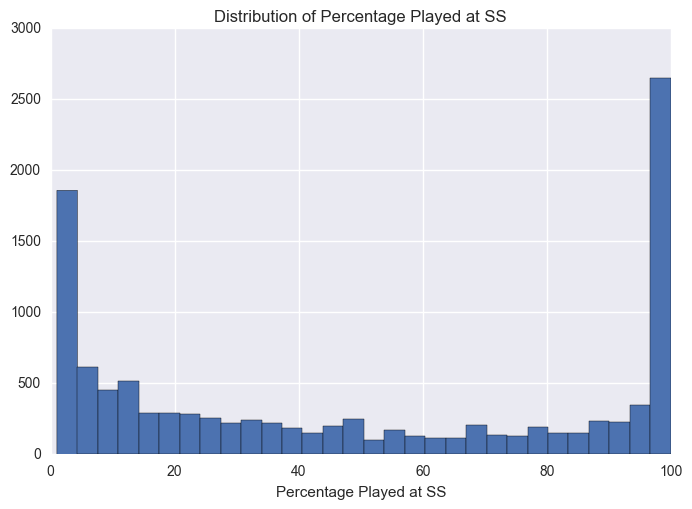

count    11095.000000
mean        49.309329
std         39.029310
min          1.000000
25%          9.000000
50%         43.000000
75%         96.000000
max        100.000000
Name: ss%, dtype: float64
q3ss shape is: (3820, 24)


,year,player_id,g_x,ab,r,h,double,triple,hr,rbi,...,g_all,g_ss,ss%,starting_pos,allstar,g_y,po,a,e,dp
0,2015,tulowtr01,128,486.0,77.0,136.0,27.0,0.0,17.0,70.0,...,128.0,121,95.0,0.0,1,121,153.0,361.0,8.0,85.0
1,2015,correca01,99,387.0,52.0,108.0,22.0,1.0,22.0,68.0,...,99.0,99,100.0,NaN,0,99,112.0,265.0,13.0,41.0
2,2015,gregodi01,155,525.0,57.0,139.0,24.0,2.0,9.0,56.0,...,155.0,155,100.0,NaN,0,155,177.0,430.0,13.0,77.0
3,2015,galvifr01,151,559.0,63.0,147.0,14.0,5.0,7.0,50.0,...,151.0,146,97.0,NaN,0,150,216.0,409.0,17.0,90.0
4,2015,escobal02,148,612.0,76.0,157.0,20.0,5.0,3.0,47.0,...,148.0,148,100.0,6.0,1,148,217.0,417.0,13.0,80.0


In [400]:
#bringing in the allstar csv
allstar = pd.read_csv('../Data/all_star.csv')
ss_as = allstar.loc[:,['player_id','year','starting_pos']]
ss_as['starting_pos'] = ss_as['starting_pos'].apply(lambda x: x if x > 0 else 0)
ss_as['allstar'] = 1
# starting pos = 6 is ss

#if a player has played a game at shortstop
ss = appearances[appearances['g_ss']>0].loc[:,['player_id','team_id','year','g_all','g_ss']]

#summing up appearances and batting data (some players played on more than one team in ayear)
ss_sum = ss.groupby(['year','player_id'])['g_all','g_ss'].sum()
ss_sum.reset_index(inplace = True)
#batting data
q3bat = batting.groupby(['year','player_id'])['g','ab','r','h','double','triple','hr','rbi',\
                                         'sb','cs','bb','so','ibb','hbp','sh','sf','g_idp'].sum()
q3bat.reset_index(inplace = True)

#merging the two dataframes (appearances and batting)
ss_batting = pd.merge(q3bat,ss_sum)
ss_batting['ss%'] = (100*(ss_batting['g_ss'] / ss_batting['g_all'])).round(0)
print 'ss_batting shape is:',ss_batting.shape
print 'ss_as shape is:',ss_as.shape

#merging (left merge) for batting data and whether they were allstar or not
q3ss = pd.merge(ss_batting,ss_as,how='left')

#distribution of players percentage at shortstop
q3ss['ss%'].hist(bins=30)
plt.title('Distribution of Percentage Played at SS')
plt.xlabel('Percentage Played at SS');
plt.show()

#let the cutoff be at 80%
print q3ss[q3ss['ss%']>=0.8]['ss%'].describe()
#there are some null values


#median percentage of games at SS is 99%
q3ss = q3ss[q3ss['ss%']>=80].copy()
q3ss['allstar'] = q3ss['allstar'].apply(lambda x: x if x > 0 else 0).astype(int)
print 'q3ss shape is:',q3ss.shape

#this is technically incorrect because allstar is played in the middle of the season while stats show full season
# could have a dropoff in second half, or an on fire in the second half.
#bringing in defensive stats
fielding = pd.read_csv('../Data/fielding.csv')
defense = fielding.groupby(['year','player_id'])['g','po','a','e','dp'].sum()
defense.reset_index(inplace = True)

#merging the defense data to current dataframe
q3all = pd.merge(q3ss,defense,how='left',on=['year','player_id'])
q3all.sort_values('year',ascending=False,inplace=True)
q3all.reset_index(inplace = True,drop=True)
q3all.head()



Because there could be multiple shortstops selected to the allstar team, regardless if they start at ss, come off bench, or play DH, need to include non-starters as well. Including only the last 100 shortstops means that Alex Rodriguez and Barry Larkin are the only all-stars that aren't included as the last 100 allstar shortstops. This would throw off analysis because they were allstars, but not in the last 100 (other ss were in the L100 in that same year). Either we remove them from the dataset or include them in the analysis. The analysis below will keep them because they were allstars and if we are keeping other allstar ss in that year (1997) we need to keep Alex Rodriguez and Barry Larkin.


In [393]:
#finding out the allstar shortstops (L101)
as_counter = 0
L100 = []
for allstar in q3all['allstar']:
    if (allstar==1) and as_counter <=101:
        L100.append(1)
        as_counter+=1
    else:
        L100.append(0)
q3all['L100'] = L100
print 'Cutoff year for the L102 SS to make allstar game is:',q3all[q3all['L100']==1]['year'].min()
q3L100 = q3all[q3all['year']>=1997].copy()
print 'Number of allstar SS in this analysis:',q3L100[q3L100['allstar']==1].shape[0]

Cutoff year for the L102 SS to make allstar game is: 1997
Number of allstar SS in this analysis: 102


Descriptive Stats for games played is:
count    702.000000
mean     110.420228
std       49.547180
min        1.000000
25%       79.250000
50%      133.000000
75%      151.000000
max      162.000000
Name: g_x, dtype: float64


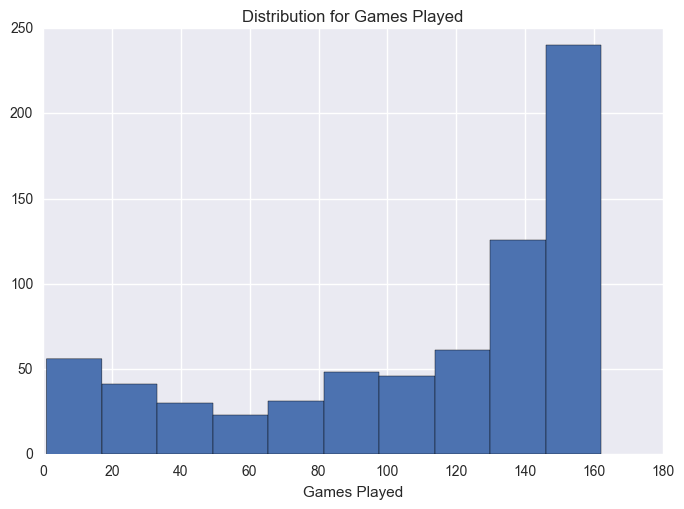

,year,player_id,g_x,ab,r,h,double,triple,hr,rbi,...,g_y,po,a,e,dp,L100,SLG%,OBP%,OPS,avg
0,2015,tulowtr01,128,486.0,77.0,136.0,27.0,0.0,17.0,70.0,...,121,153.0,361.0,8.0,85.0,1,0.440,0.337,0.777,0.280
2,2015,gregodi01,155,525.0,57.0,139.0,24.0,2.0,9.0,56.0,...,155,177.0,430.0,13.0,77.0,0,0.370,0.318,0.688,0.265
3,2015,galvifr01,151,559.0,63.0,147.0,14.0,5.0,7.0,50.0,...,150,216.0,409.0,17.0,90.0,0,0.343,0.302,0.645,0.263
4,2015,escobal02,148,612.0,76.0,157.0,20.0,5.0,3.0,47.0,...,148,217.0,417.0,13.0,80.0,1,0.320,0.293,0.613,0.257
6,2015,desmoia01,156,583.0,69.0,136.0,27.0,2.0,19.0,62.0,...,155,226.0,417.0,27.0,94.0,0,0.384,0.290,0.674,0.233
9,2015,hechaad01,130,470.0,54.0,132.0,17.0,6.0,5.0,48.0,...,130,173.0,373.0,9.0,93.0,0,0.374,0.315,0.689,0.281
10,2015,cabreas01,143,505.0,66.0,134.0,28.0,5.0,15.0,58.0,...,136,150.0,284.0,9.0,51.0,0,0.430,0.315,0.745,0.265
11,2015,bogaexa01,156,613.0,84.0,196.0,35.0,3.0,7.0,81.0,...,156,236.0,429.0,11.0,95.0,0,0.421,0.355,0.776,0.320
13,2015,aybarer01,156,597.0,74.0,161.0,30.0,1.0,3.0,44.0,...,154,244.0,359.0,17.0,71.0,0,0.338,0.301,0.639,0.270
14,2015,andruel01,160,596.0,69.0,154.0,34.0,2.0,7.0,62.0,...,160,248.0,516.0,22.0,114.0,0,0.357,0.309,0.666,0.258


In [394]:
#descriptive stats
print 'Descriptive Stats for games played is:'
print q3L100['g_x'].describe()

#distribution of games played
q3L100['g_x'].hist()
plt.title('Distribution for Games Played')
plt.xlabel('Games Played')
plt.show();

#lets cutoff the gamex played lower limit to 120. since the number of games in a year is 162
#half of it is 81. we would not know if the games played was in the first half or second half.
#ensuring 120 would at least give a minimum of almost 40 games in the first half.

g_x_limit = 120
q3L100 = q3L100[q3L100['g_x']>=g_x_limit]

#feature engineering for slugging %
#calc for slugging % = Total Bases = hits including double (x2) triple(x3), hr (x4) / AB
tb = []
for hits,doubles,triples,hr in zip(q3L100['h'],q3L100['double'],q3L100['triple'],q3L100['hr']):
    singles = hits - doubles - triples - hr
    tb_2 = doubles * 2
    tb_3 = triples * 3
    tb_4 = hr * 4
    total_bases = singles + tb_2 + tb_3 + tb_4
    tb.append(total_bases)
    
#feature engineering - calculate OBP (on-base percentage), SLG (slugging percentage), and OPS (onbase + slugging)
#also calculating batting average
q3L100['TB'] = tb
q3L100['SLG%'] = (q3L100['TB'] / q3L100['ab']).round(3)
q3L100['OBP%'] = ((q3L100['h'] + q3L100['hbp'] + q3L100['bb']) / \
                            (q3L100['ab'] + q3L100['hbp'] + q3L100['bb'] +q3L100['sf'] )).round(3)
q3L100['OPS'] = (q3L100['SLG%'] + q3L100['OBP%']).round(3)
q3L100['avg'] = (q3L100['h'] / q3L100['ab']).round(3)

#no longer need the following columns
del q3L100['TB'],q3L100['cs'],q3L100['sh'],q3L100['sf'],q3L100['g_idp'],q3L100['hbp'],q3L100['ibb']
q3L100.head(10)

In [387]:
#calculating metrics by allstar/non-allstars per year 
q3 = q3L100.groupby(['year','L100'])['r','h','double','hr','rbi','bb','e','dp','SLG%','OBP%','OPS','avg'].mean()
q3.reset_index(inplace = True)
q3.head(10)

,year,L100,r,h,double,hr,rbi,bb,e,dp,SLG%,OBP%,OPS,avg
0,1997,0,63.650000,132.700000,23.300000,7.300000,50.350000,37.650000,14.900000,83.200000,0.361000,0.312800,0.673800,0.259450
1,1997,1,96.750000,174.500000,38.500000,19.750000,78.250000,44.750000,20.000000,92.000000,0.477500,0.350750,0.828250,0.295000
2,1998,0,68.055556,139.166667,27.222222,10.277778,57.166667,39.111111,18.666667,87.277778,0.391667,0.321778,0.713444,0.266722
3,1998,1,103.750000,182.000000,27.000000,16.500000,72.250000,53.000000,13.000000,89.750000,0.438750,0.362250,0.801000,0.301000
4,1999,0,76.466667,146.600000,24.866667,13.866667,65.333333,38.400000,17.333333,97.466667,0.411600,0.325400,0.737000,0.274533
5,1999,1,107.600000,185.200000,34.600000,16.400000,81.200000,63.000000,17.400000,81.800000,0.488200,0.390200,0.878400,0.321800
6,2000,0,77.937500,142.187500,26.312500,12.062500,63.625000,48.312500,17.500000,95.750000,0.400250,0.329875,0.730125,0.265188
7,2000,1,107.800000,179.000000,35.600000,22.600000,91.400000,68.200000,19.000000,85.200000,0.510400,0.391400,0.901800,0.318000
8,2001,0,68.882353,139.941176,24.705882,9.647059,57.294118,37.764706,15.529412,88.117647,0.377353,0.315706,0.693059,0.262353
9,2001,1,113.500000,194.500000,33.750000,31.000000,90.000000,56.500000,16.000000,98.250000,0.523250,0.367000,0.890250,0.306750


In [402]:
#finding correlation between all features
q3.corr()

,year,L100,r,h,double,hr,rbi,bb,e,dp,SLG%,OBP%,OPS,avg
year,1.000000,0.000000,-0.446803,-0.224679,-0.268889,-0.295159,-0.337779,-0.396918,-0.560060,-0.378451,-0.309799,-0.320360,-0.319254,-0.245772
L100,0.000000,1.000000,0.735811,0.851422,0.641623,0.708181,0.779170,0.604329,-0.142261,0.124975,0.798546,0.800489,0.813949,0.841729
r,-0.446803,0.735811,1.000000,0.925716,0.811380,0.831907,0.903669,0.896379,0.280364,0.386119,0.915352,0.914967,0.932081,0.887319
h,-0.224679,0.851422,0.925716,1.000000,0.858975,0.788233,0.896622,0.769249,0.132427,0.303787,0.901543,0.904190,0.919093,0.939912
double,-0.268889,0.641623,0.811380,0.858975,1.000000,0.657729,0.802570,0.655458,0.416206,0.291882,0.789019,0.739986,0.786159,0.772970
hr,-0.295159,0.708181,0.831907,0.788233,0.657729,1.000000,0.913811,0.722899,0.178146,0.504881,0.931172,0.755820,0.886111,0.742255
rbi,-0.337779,0.779170,0.903669,0.896622,0.802570,0.913811,1.000000,0.792198,0.249564,0.443993,0.947655,0.861484,0.934541,0.860802
bb,-0.396918,0.604329,0.896379,0.769249,0.655458,0.722899,0.792198,1.000000,0.274494,0.196491,0.815816,0.892068,0.857903,0.790662
e,-0.560060,-0.142261,0.280364,0.132427,0.416206,0.178146,0.249564,0.274494,1.000000,0.228516,0.216414,0.144847,0.195008,0.098750
dp,-0.378451,0.124975,0.386119,0.303787,0.291882,0.504881,0.443993,0.196491,0.228516,1.000000,0.363747,0.145707,0.293084,0.153945


In [396]:
#calculating target and data
y = q3['L100']
to_scale = q3.iloc[:,2:10]

#scaling the features
from sklearn.preprocessing import MinMaxScaler
scaled = pd.DataFrame(MinMaxScaler().fit_transform(to_scale),columns=to_scale.columns)
data = pd.concat([scaled,q3.iloc[:,-4:]],axis=1)

#LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
lr = LogisticRegressionCV(cv=5)
lr = lr.fit(data,y)
lr_pred = lr.predict(data)
coef = pd.DataFrame(lr.coef_,columns=data.columns)
coef= coef.T
coef.rename(columns = {0:'Log Odds'},inplace = True)
coef['odds'] = coef['Log Odds'].apply(lambda x: np.exp(x))
coef

,Log Odds,odds
r,1.439165,4.217173
h,5.468882,237.194919
double,0.752790,2.122914
hr,3.386483,29.561813
rbi,4.267187,71.320700
bb,-0.628754,0.533256
e,-4.767423,0.008502
dp,-2.755527,0.063575
SLG%,0.704970,2.023787
OBP%,0.362220,1.436514


#### Q3 Conclusion

Hits has a higher coefficient than any other metric. Looking at the correlation table above, it also suggests the same conclusion, that Hits is the most important metric that determines the last 102 shortstops that made the allstar game. Below shows feature importances from a RandomForest algorithm, which also highlights that Hits is the most important feature.

In [204]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train,X_test, y_train,y_test = train_test_split(data,y,test_size=0.33,random_state=25)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_test)
pd.concat([pd.Series(data.columns,name='Features'),pd.Series(rf.feature_importances_,name='Values')],axis=1).\
            sort_values('Values',ascending=False)
    

,Features,Values
1,h,0.158545
3,hr,0.134591
4,rbi,0.117227
10,OPS,0.106204
9,OBP%,0.104097
0,r,0.084109
8,SLG%,0.067489
11,avg,0.065309
2,double,0.060687
5,bb,0.048291


### Question 4: What stadium/park do you predict will give up the most errors by a center fielder over the next 5 years and why?

Note:

There was an error in home_game.csv, where last two years for chicago cubs and whitesox had their stadiums switched. I changed it in the csv file: Cubs play at Wrigley and White Sox play at US Cellular.

Strategy:

Finding the errors by CF in appearances, merging with team csv will get you the amount of errors by a CF in total, not just home, but also on away. Team csv shows team statistics. We do not know the distribution of errors, but we do know that home games are 50% of total games. If we assume an uniform distribution, we assume half the errors should be at home, and half away. There is no need to divide all the errors in half, because the same result would be reached. We are trying to predict the park with most CF errors.


In knowning the sport and after looking at the data, given that there is no data on individual game, we are not able to get the true number of errors by CF at a certain park, thus would have to assume a distribution of errors. The best way to find out which park has the most errors would be finding the ratio of errors by CF to errors by total team. Assuming uniform distribution, half of the errors will occur at their home ballpark. 

In [330]:
#appearances for CF
cfa = appearances[appearances['g_cf']>0].loc[:,['year','player_id','team_id','g_all','g_cf']]
#finding number of errors by CF/OF
cf_errors = fielding[(fielding['pos']=='OF') | (fielding['pos']=='CF') ].loc[:,['year','player_id','team_id','pos','e']]
#merging appearances and errors for CF
cf = pd.merge(cfa,cf_errors)
#dropping all null values
cf.dropna(inplace = True)

#summing games and errors by team/year
cf_gb = cf.groupby(['year','team_id'])['g_all','g_cf','e'].sum()
cf_gb.reset_index(inplace = True)

#finding metrics for errors
cf_stats = cf_gb.groupby('year')['e'].agg([min,max,np.median,np.mean,np.std])
cf_stats.reset_index(inplace = True)
#rounding mean and standard deviation
cf_stats['mean'] = cf_stats['mean'].round(1)
cf_stats['std'] = cf_stats['std'].round(1)
#merging the stats with the previous dataframe
cf1 = pd.merge(cf_gb,cf_stats)
#calculating min-max scaling - numbers b/w 0 and 1
cf1['norm_e'] = ((cf1['e']-cf1['min']) / (cf1['max']-cf1['min'])).round(2)
#calculating standardize scaling - Z-score
cf1['Z_e'] = ((cf1['e']-cf1['mean'])/cf1['std']).round(2)
#finding all errors above the mean
cf1['e_above_mean'] = cf1['norm_e'].apply(lambda x: 1 if x>.5 else 0)
del cf1['min'],cf1['max'],cf1['std'],cf1['Z_e']
cf1.tail()

,year,team_id,g_all,g_cf,e,median,mean,norm_e,e_above_mean
2792,2015,SLN,568.0,228,9.0,7.0,8.2,0.50,0
2793,2015,TBA,348.0,194,7.0,7.0,8.2,0.36,0
2794,2015,TEX,346.0,204,7.0,7.0,8.2,0.36,0
2795,2015,TOR,340.0,169,6.0,7.0,8.2,0.29,0
2796,2015,WAS,407.0,172,12.0,7.0,8.2,0.71,1


In [318]:
#bringing in the team csv
team = pd.read_csv('../Data/team.csv')
print team.columns
#using only a subset of the features
col_team = ['year','team_id','g','ghome','ra','er','e','bpf','ppf','park']
team = team[col_team]
#calculating unearned runs - runs due to errors
team['unearned_run'] = team['ra'] - team['er']

team.tail()

Index([u'year', u'league_id', u'team_id', u'franchise_id', u'div_id', u'rank',
       u'g', u'ghome', u'w', u'l', u'div_win', u'wc_win', u'lg_win', u'ws_win',
       u'r', u'ab', u'h', u'double', u'triple', u'hr', u'bb', u'so', u'sb',
       u'cs', u'hbp', u'sf', u'ra', u'er', u'era', u'cg', u'sho', u'sv',
       u'ipouts', u'ha', u'hra', u'bba', u'soa', u'e', u'dp', u'fp', u'name',
       u'park', u'attendance', u'bpf', u'ppf', u'team_id_br',
       u'team_id_lahman45', u'team_id_retro'],
      dtype='object')


,year,team_id,g,ghome,ra,er,e,bpf,ppf,park,unearned_run
2800,2015,LAN,162,81.0,595,553,75,101,98,Dodger Stadium,42
2801,2015,SFN,162,81.0,627,597,78,99,97,AT&T Park,30
2802,2015,ARI,162,81.0,713,659,86,107,106,Chase Field,54
2803,2015,SDN,162,81.0,731,655,92,98,97,Petco Park,76
2804,2015,COL,162,81.0,844,799,95,119,118,Coors Field,45


In [364]:
#merging cf error by team and team stats
cf_home = pd.merge(cf1,team,on=['year','team_id'])
#calculating % of errors by CF
cf_home['cf_e%'] = (100*(cf_home['e_x'] / cf_home['e_y'])).round(2)

#assume uniform error, as in half are away and half are at home? most likely inaccurate

most_errors = cf_home[(cf_home['year']>=year_limit)].groupby(['year','team_id'])['cf_e%'].max().to_frame()

most_errors.reset_index(inplace = True)
me_pt = most_errors.pivot_table(index='team_id',columns='year',values='cf_e%')

l3_mean = me_pt.iloc[:,-3:].mean(axis=1).round(2)

me_pt['L3_mean'] = l3_mean
me_pt.sort_values('L3_mean',ascending=False).head(10)

year,2008,2009,2010,2011,2012,2013,2014,2015,L3_mean
team_id,,,,,,,,,
LAN,6.93,3.61,7.14,8.24,7.14,12.84,18.69,14.67,15.40
ARI,4.42,10.48,11.76,6.67,7.78,16.00,16.83,12.79,15.21
HOU,7.46,3.85,2.91,1.72,7.63,7.20,22.64,14.12,14.65
PIT,4.67,4.11,4.72,8.93,6.25,12.26,17.43,11.48,13.72
SEA,13.13,7.62,4.55,5.56,8.33,12.50,23.17,5.32,13.66
COL,12.50,11.49,6.93,12.24,7.38,7.78,27.36,5.26,13.47
CHN,14.14,6.67,7.14,7.46,3.81,5.00,27.18,5.41,12.53
MIN,12.04,10.53,8.97,9.24,7.48,6.17,19.59,11.63,12.46
TEX,12.88,9.43,8.57,11.40,9.41,8.14,22.64,5.88,12.22


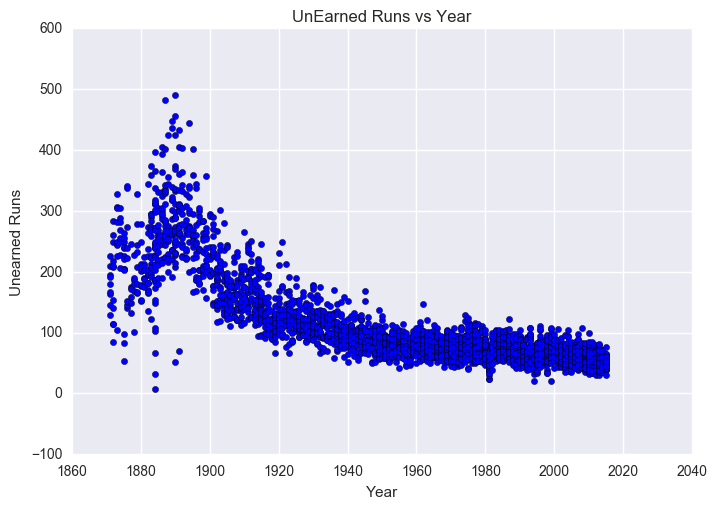

In [284]:
plt.scatter(x=team['year'],y=team['unearned_run'])
plt.title('UnEarned Runs vs Year')
plt.xlabel('Year')
plt.ylabel('Unearned Runs')
plt.show()
#unearned runs (runs due to errors) are decreasing overtime

In [397]:
#looking at year 2008 and later
year_limit = 2008

#calculating latest ballparks of mlb teams
hg = home_game[home_game['year']>=year_limit].loc[:,['year','team_id','park_id','games']]
#finding the max year for each ballpark - only going to use the latest ballpark
hg1 = hg.groupby(['team_id','park_id'])['year'].max().to_frame('max_yr')
hg1.reset_index(inplace = True)
#count of years/sum of games at each ballpark
count_hg = hg.groupby(['team_id','park_id'])['year','games'].agg({'year':len,'games':sum})
count_hg.reset_index(inplace = True)
#merging dataframes
hg2 = pd.merge(hg1,count_hg)
hg3 = pd.merge(hg2,park.loc[:,['park_id','park_name','city','state','country']])

#removing non-US/canada fields
#there were some number of games played in another ballpark, less than 10. lets remove all games played in stadium < 10

hg4 = hg3[((hg3['country']=='US') | (hg3['country']=='CA')) & (hg3['games']>10)].sort_values('team_id')

#some new stadiums have been built in the last 8 years. thus we need to include the new ones and not the old ones
#the latee
hg5 = hg4[hg4['max_yr']==2014]
#print hg5['max_yr'] - hg5['year']+1
#there are 4 teams that built stadiums after 2008.

### Q4 Conclusion

Ballparks come and go, so we need to analyze last number of years, so we can predict number of errors by CF. Just from knowing the data and the sport, this isn't very predictable for the following:

* Controlling for Talent is difficult
* Unable to know where the error took place.

As above, assuming an uniform distribution of errors, we know that teams play 50% of games at home, thus 50% of errors should be at home. However, this would be an incorrect assumption, as individual game data would be needed. While there would be a higher number of errors at home than any other field, it remains to be seen if its 50%. One theory could be that the learning rate for CF would be that the errors would be less than 50%. 

Finding the % of errors by CF (sum of errors by cf by sum of errors by total team) by year, we find that Dodger and Arizona's stadium both have a little north of 15% (average of last 3 years). Thus it would be my prediction that those two would be one of the top stadiums to have the most errors by CF.

Though, as an Astros fan, if the current RFer is indeed moving to CFer, and the fact that houston Minute Main Park is ranked three in the table above, I could venture a guess and that say that could be number 1, especially considering it has the deepest center in MLB.